In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/datasets-prudential-life/sample_submission.csv
/kaggle/input/datasets-prudential-life/train.csv
/kaggle/input/datasets-prudential-life/test.csv
/kaggle/input/prudential-life-insurance-assessment/train.csv.zip
/kaggle/input/prudential-life-insurance-assessment/sample_submission.csv.zip
/kaggle/input/prudential-life-insurance-assessment/test.csv.zip


In [77]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from math import sqrt
import tensorflow_decision_forests as tfdf
import lightgbm as lgb
import scipy.stats as st
import xgboost 


In [3]:
dataset_train = pd.read_csv('/kaggle/input/datasets-prudential-life/train.csv',sep=',')
dataset_test = pd.read_csv('/kaggle/input/datasets-prudential-life/test.csv',sep=',')
dataset_sample_submission = pd.read_csv('/kaggle/input/datasets-prudential-life/sample_submission.csv',sep=',')

In [4]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [5]:
dataset_train

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,1,D1,10,0.230769,2,3,1,0.074627,0.709091,...,0,0,0,0,0,0,0,0,0,4
59377,79143,1,D3,26,0.230769,2,3,1,0.432836,0.800000,...,0,0,0,0,0,0,0,0,0,7
59378,79144,1,E1,26,0.076923,2,3,1,0.104478,0.745455,...,0,0,0,0,0,0,0,0,0,8
59379,79145,1,D2,10,0.230769,2,3,1,0.507463,0.690909,...,1,0,0,0,0,0,0,0,0,8


# 1 Data cleaning
- visualise the dataset
- reflexion about the variable : which variables are interesting to keep 
- impute, delete the missing value

In [6]:
# print average missing values by variable
dataset_train.isna().mean()

Id                    0.0
Product_Info_1        0.0
Product_Info_2        0.0
Product_Info_3        0.0
Product_Info_4        0.0
                     ... 
Medical_Keyword_45    0.0
Medical_Keyword_46    0.0
Medical_Keyword_47    0.0
Medical_Keyword_48    0.0
Response              0.0
Length: 128, dtype: float64

<Axes: >

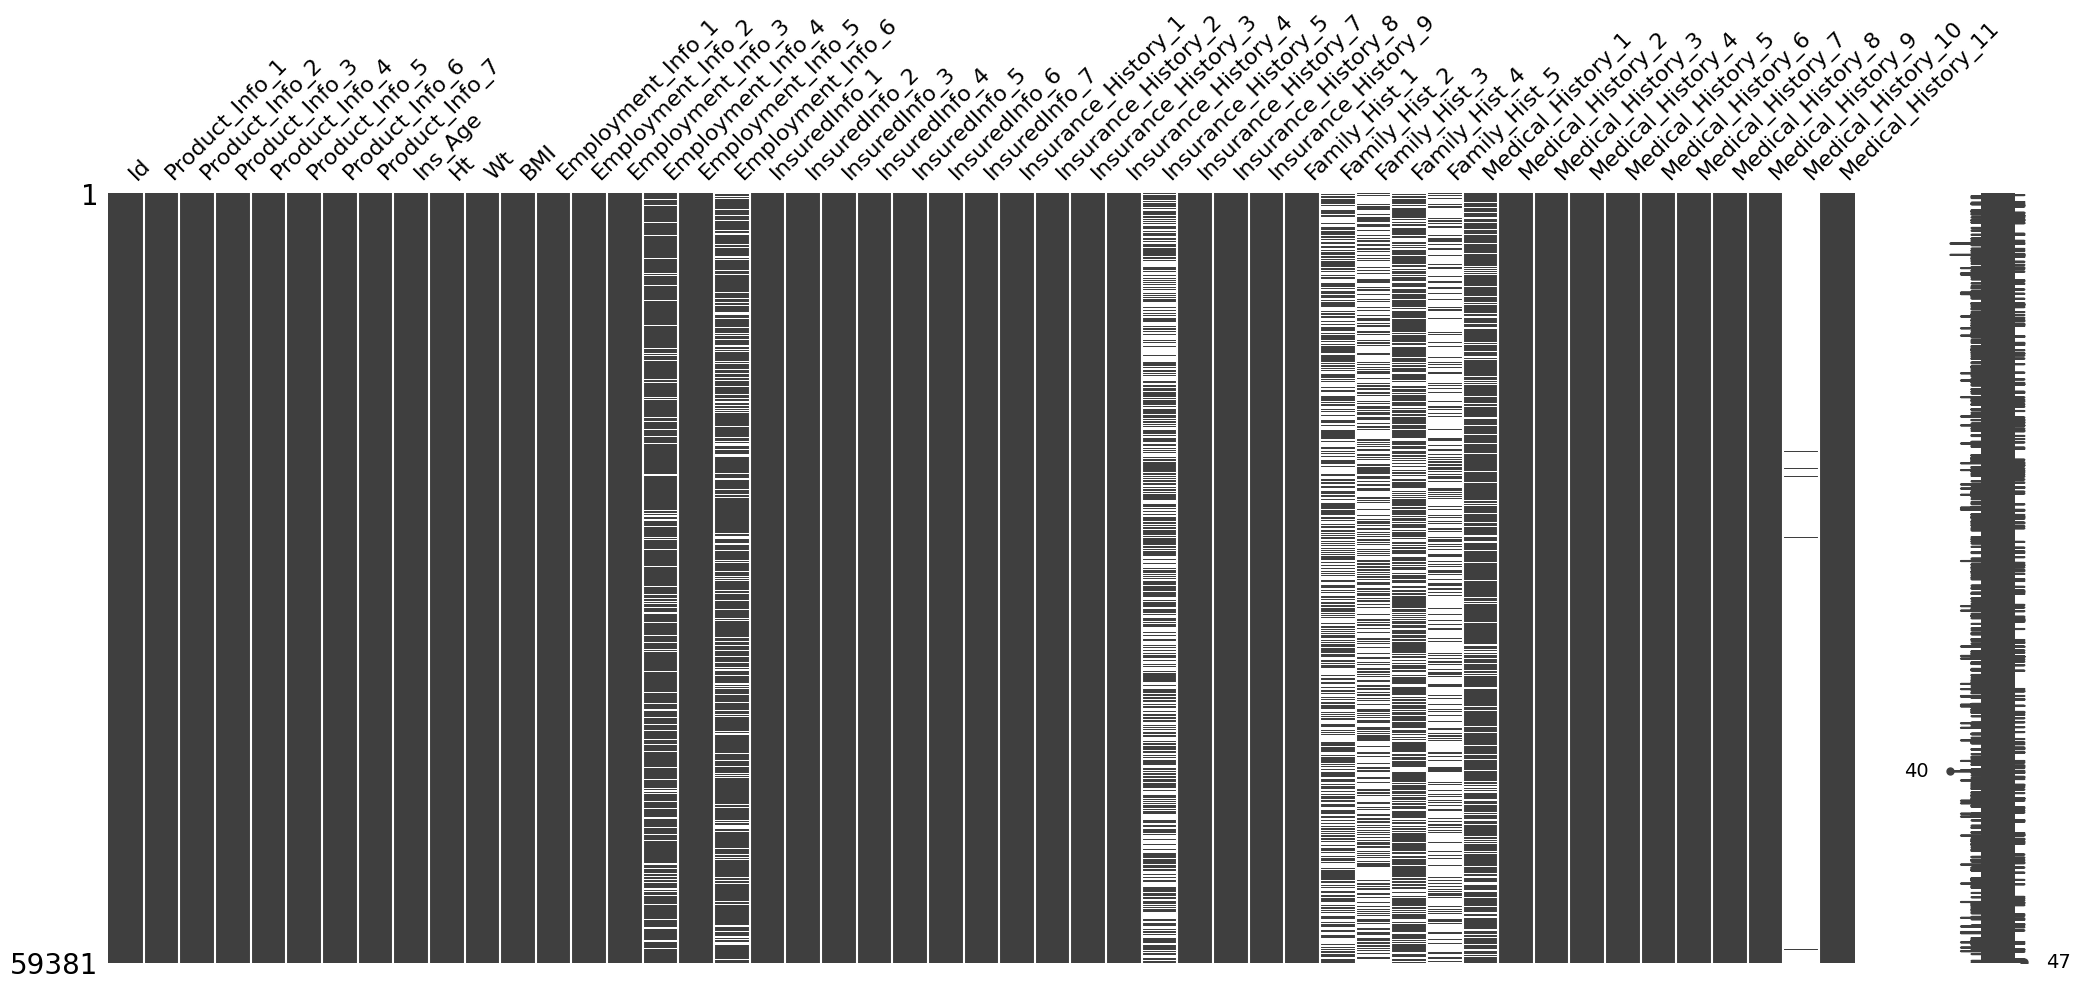

In [7]:
msno.matrix(dataset_train.iloc[:,:49])

<Axes: >

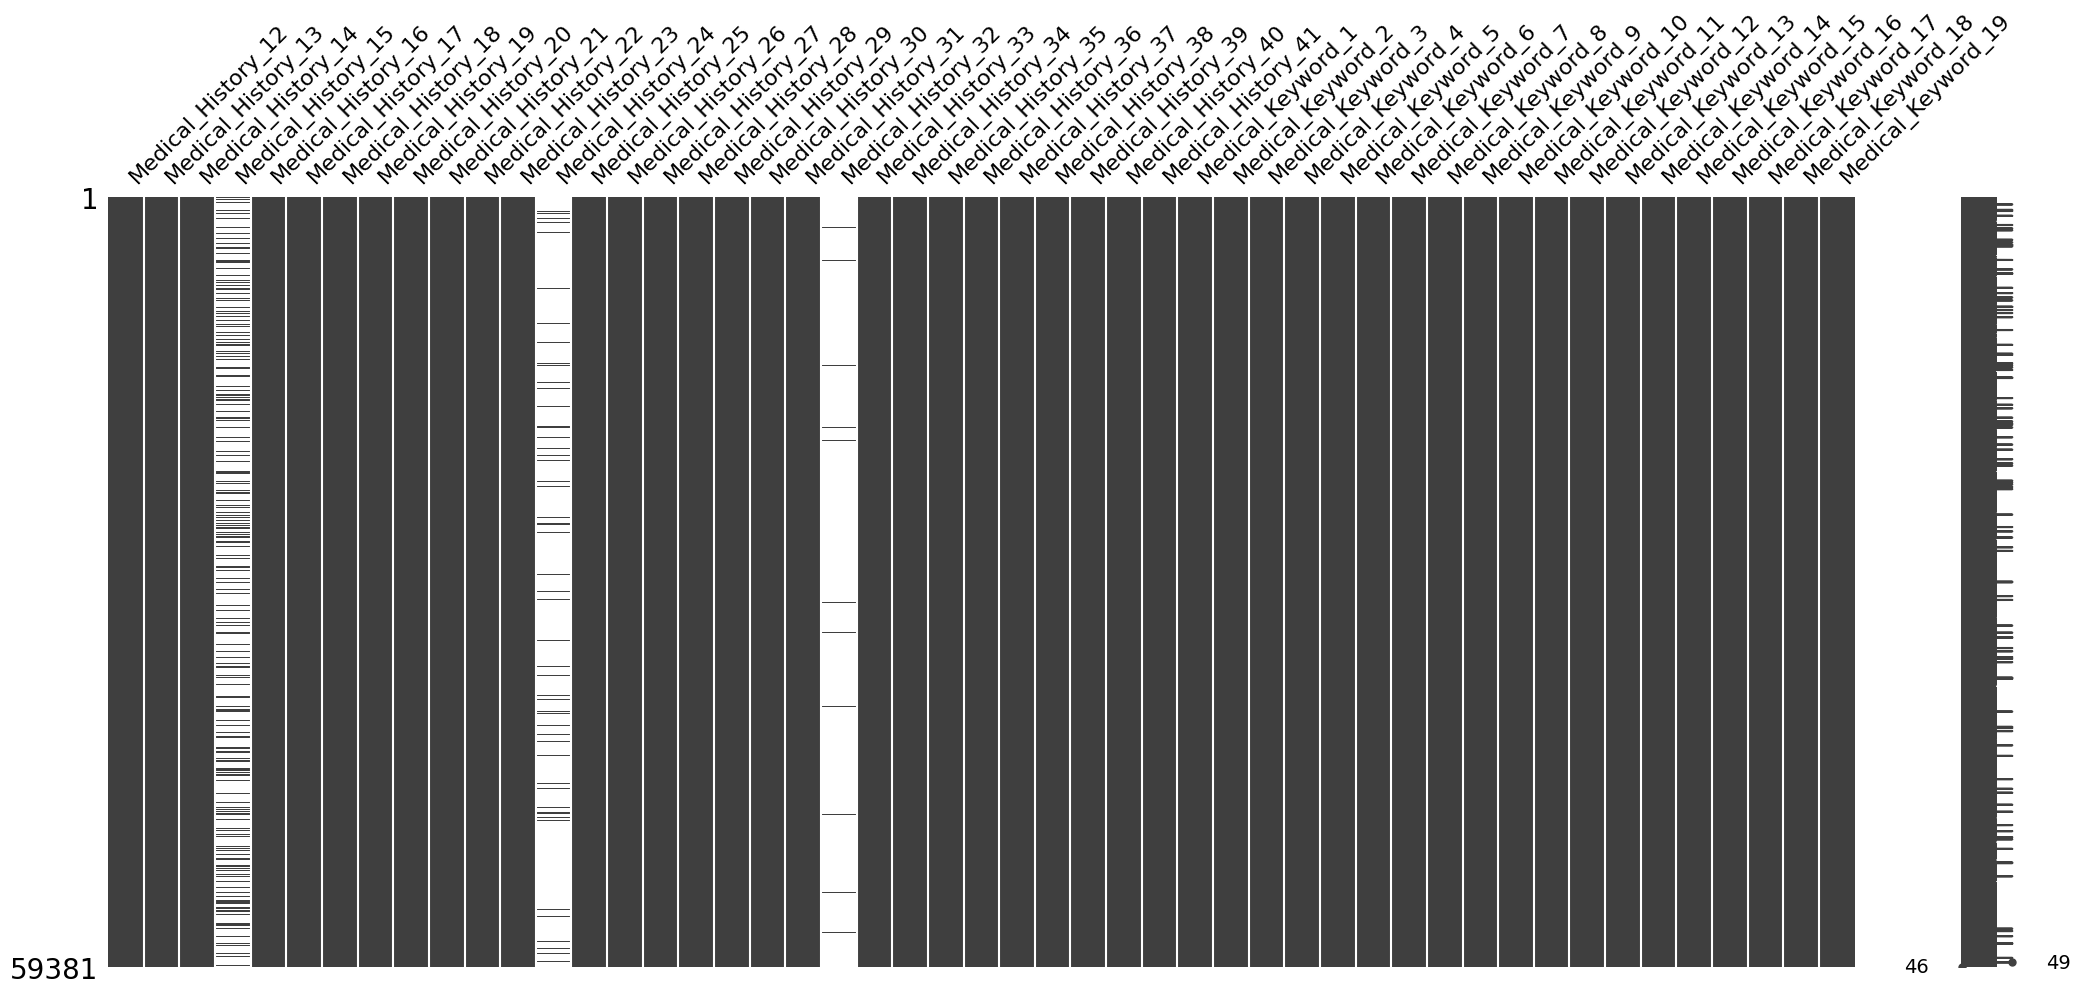

In [8]:
msno.matrix(dataset_train.iloc[:,49:98])

<Axes: >

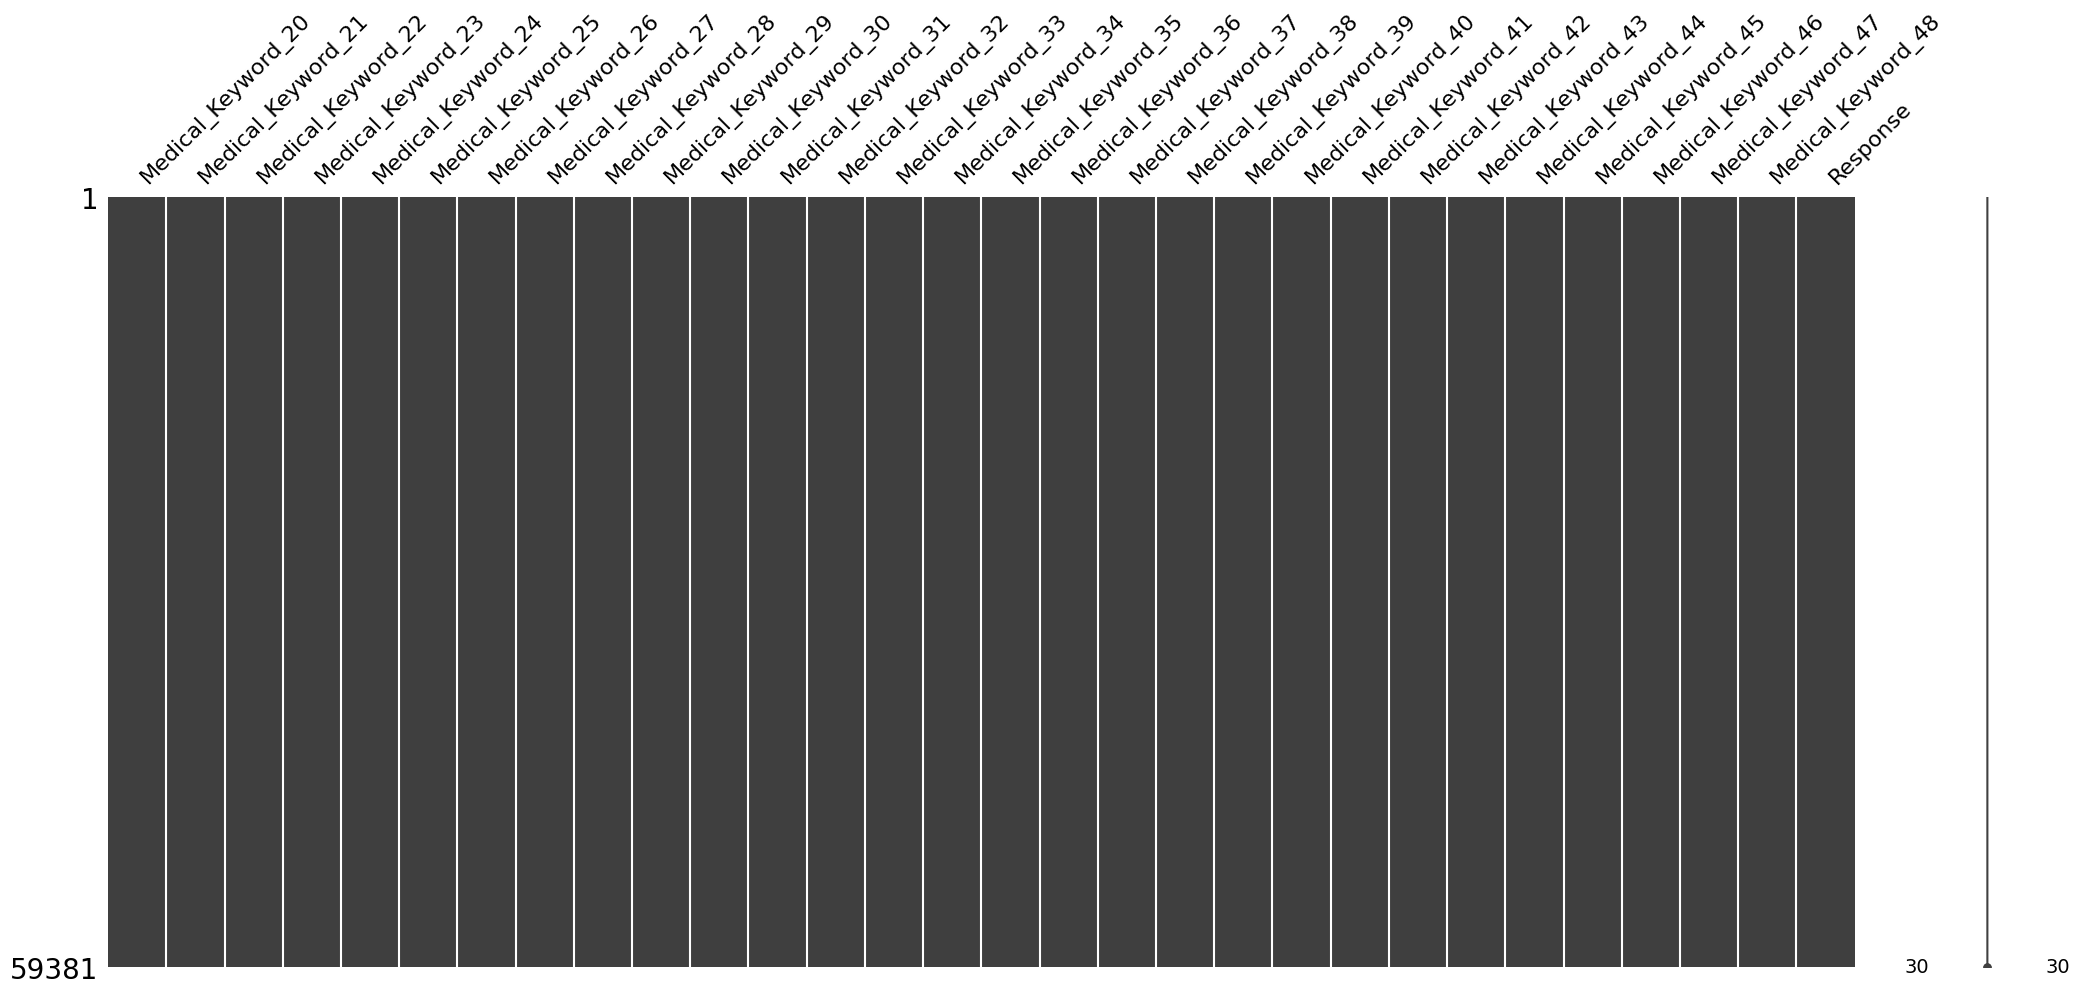

In [9]:
msno.matrix(dataset_train.iloc[:,98:])

### information about varaibles
- Product_info_1 A set of normalized variables relating to the product applied for
- Ins_Age : Normalized age of applicant
- Ht : Normalized height of applicant
- Wt : Normalized weight of applicant
- BMI : Normalized BMI of applicant
- Medical_History_1-41  : A set of normalized variables relating to the medical history of the applicant.
- Employment_Info_1-6 : A set of normalized variables relating to the employment history of the applicant.
- InsuredInfo_1-6 : A set of normalized variables providing information about the applicant.
- Insurance_History_1-9 : A set of normalized variables relating to the insurance history of the applicant.
- Family_Hist_1-5 A set of normalized variables relating to the family history of the applicant.
- Medical_Keyword_1-48 : A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.
- Response : This is the target variable, an ordinal variable relating to the final decision associated with an application.

In [10]:
dataset_train

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,1,D1,10,0.230769,2,3,1,0.074627,0.709091,...,0,0,0,0,0,0,0,0,0,4
59377,79143,1,D3,26,0.230769,2,3,1,0.432836,0.800000,...,0,0,0,0,0,0,0,0,0,7
59378,79144,1,E1,26,0.076923,2,3,1,0.104478,0.745455,...,0,0,0,0,0,0,0,0,0,8
59379,79145,1,D2,10,0.230769,2,3,1,0.507463,0.690909,...,1,0,0,0,0,0,0,0,0,8


In [11]:
# Here are the variables with more than 10% missing values
mean_missing_var = dataset_train.isna().mean() > 0.1
missing_var = mean_missing_var[mean_missing_var == True]
missing_var

Employment_Info_4      True
Employment_Info_6      True
Insurance_History_5    True
Family_Hist_2          True
Family_Hist_3          True
Family_Hist_4          True
Family_Hist_5          True
Medical_History_1      True
Medical_History_10     True
Medical_History_15     True
Medical_History_24     True
Medical_History_32     True
dtype: bool

# 1.1 missing values
- All variables with missing values are normalized and there is not much about variable. 
- I will impute the missing value by the median value of the variable.

In [12]:
dataset_train.loc[:,missing_var.index]

,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
0,0.00000,NaN,0.000667,NaN,0.598039,NaN,0.526786,4.0,NaN,240.0,NaN,NaN
1,0.00000,0.0018,0.000133,0.188406,NaN,0.084507,NaN,5.0,NaN,0.0,NaN,NaN
2,0.00000,0.0300,NaN,0.304348,NaN,0.225352,NaN,10.0,NaN,NaN,NaN,NaN
3,0.00000,0.2000,NaN,0.420290,NaN,0.352113,NaN,0.0,NaN,NaN,NaN,NaN
4,0.00000,0.0500,NaN,0.463768,NaN,0.408451,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
59376,0.00000,0.0250,NaN,0.217391,NaN,0.197183,NaN,0.0,NaN,32.0,NaN,NaN
59377,0.00001,0.3500,0.000267,0.565217,NaN,0.478873,NaN,24.0,NaN,NaN,NaN,NaN
59378,0.00000,NaN,NaN,0.173913,NaN,0.126761,NaN,NaN,NaN,NaN,NaN,NaN
59379,NaN,NaN,NaN,NaN,0.372549,0.704225,NaN,0.0,NaN,240.0,NaN,NaN


In [13]:
dataset_train.loc[:,missing_var.index].describe()

,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
count,52602.000000,48527.000000,33985.000000,30725.000000,25140.000000,40197.000000,17570.000000,50492.000000,557.000000,14785.000000,3801.000000,1107.000000
mean,0.006283,0.361469,0.001733,0.474550,0.497737,0.444890,0.484635,7.962172,141.118492,123.760974,50.635622,11.965673
std,0.032816,0.349551,0.007338,0.154959,0.140187,0.163012,0.129200,13.027697,107.759559,98.516206,78.149069,38.718774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.060000,0.000400,0.362319,0.401961,0.323944,0.401786,2.000000,8.000000,17.000000,1.000000,0.000000
50%,0.000000,0.250000,0.000973,0.463768,0.519608,0.422535,0.508929,4.000000,229.000000,117.000000,8.000000,0.000000
75%,0.000000,0.550000,0.002000,0.579710,0.598039,0.563380,0.580357,9.000000,240.000000,240.000000,64.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.943662,1.000000,240.000000,240.000000,240.000000,240.000000,240.000000


In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(random_state=0)
X_impute = imp_iter.fit_transform(dataset_train.loc[:,missing_var.index])
X_impute

array([[ 0.00000000e+00,  3.67927167e-01,  6.66667000e-04, ...,
         2.40000000e+02,  1.06961925e+02,  6.76977185e+01],
       [ 0.00000000e+00,  1.80000000e-03,  1.33333000e-04, ...,
         0.00000000e+00, -3.78146165e+00, -8.94929196e+00],
       [ 0.00000000e+00,  3.00000000e-02, -1.68934093e-03, ...,
         6.02645296e+01,  2.37678357e+01,  1.14991423e+01],
       ...,
       [ 0.00000000e+00,  4.36219078e-02, -3.52098566e-03, ...,
         4.62205347e+01,  1.70376986e+01,  6.98265414e+00],
       [ 9.91490373e-03,  6.36522820e-01, -3.35341637e-03, ...,
         2.40000000e+02,  1.06852217e+02,  6.62377596e+01],
       [ 1.12243700e-02,  3.00000000e-01,  1.35308201e-03, ...,
         1.47961599e+02,  8.00000000e+00,  1.63900557e+01]])

In [18]:
dataset_train.loc[:,missing_var.index] = X_impute.copy()
dataset_train.loc[:,missing_var.index]

,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
0,0.000000,0.367927,0.000667,0.602417,0.598039,0.545260,0.526786,4.000000,165.048389,240.000000,106.961925,67.697718
1,0.000000,0.001800,0.000133,0.188406,0.080242,0.084507,0.535017,5.000000,44.147739,0.000000,-3.781462,-8.949292
2,0.000000,0.030000,-0.001689,0.304348,0.353097,0.225352,0.497915,10.000000,76.666670,60.264530,23.767836,11.499142
3,0.000000,0.200000,0.000313,0.420290,0.411431,0.352113,0.487696,0.000000,90.371368,94.304771,40.459543,20.076581
4,0.000000,0.050000,0.000024,0.463768,0.439309,0.408451,0.432454,8.132429,95.538591,98.745816,41.610193,23.289352
...,...,...,...,...,...,...,...,...,...,...,...,...
59376,0.000000,0.025000,0.014003,0.217391,0.283431,0.197183,0.257311,0.000000,58.516785,32.000000,11.364477,0.162674
59377,0.000010,0.350000,0.000267,0.565217,0.477964,0.478873,0.571280,24.000000,110.670315,115.897507,48.226602,31.848625
59378,0.000000,0.043622,-0.003521,0.173913,0.296604,0.126761,0.376451,9.938240,69.279798,46.220535,17.037699,6.982654
59379,0.009915,0.636523,-0.003353,0.753939,0.372549,0.704225,0.495737,0.000000,163.705716,240.000000,106.852217,66.237760


In [19]:
dataset_train.Response.unique()

array([8, 4, 1, 6, 2, 7, 3, 5])

# 1.2 outliers 

In [20]:
dataset_train.isna().mean().sort_values(ascending = False)

Employment_Info_1     0.00032
Medical_Keyword_16    0.00000
Medical_Keyword_15    0.00000
Medical_Keyword_14    0.00000
Medical_Keyword_13    0.00000
                       ...   
Family_Hist_4         0.00000
Family_Hist_3         0.00000
Family_Hist_2         0.00000
Family_Hist_1         0.00000
Medical_History_11    0.00000
Length: 128, dtype: float64

In [21]:
cols_categorial_var = dataset_train.select_dtypes(exclude = np.number).columns
cols_categorial_var

Index(['Product_Info_2'], dtype='object')

In [22]:
cols_not_categorial_var = dataset_train.select_dtypes(include = np.number).columns
cols_not_categorial_var

Index(['Id', 'Product_Info_1', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=127)

- In the dataframe some variables have outliers. 
- The variable Medical History 32 has values between 0 and 240.75 percent of the value are between 0 and 11. As you can see on the graph above there is the value in the interval 11 and 240. I cannot say that the value above the mean is the aberant. 

In [23]:
from sklearn.ensemble import IsolationForest

def search_outlier(dataset, cols):

    X = dataset.fillna(0)
    # filter the only quantitative variables
    X.loc[:,cols]
    # configure the hyperameter
    iso_forest = IsolationForest(n_estimators=200,contamination=0.01)
    
    iso_forest.fit(X.loc[:,cols])
    # predict the outlier
    res_outlier = iso_forest.predict(X.loc[:,cols])
    /
    X['outlier'] = res_outlier
    # filter the outlier 
    X[X['outlier'] == -1]
    # filter the raw that are not outliers
    mask = X.isin(X.loc[X['outlier'] == -1])
    
    df = dataset.loc[mask[~mask['outlier']].index]
    
    return df

df2_train = search_outlier(dataset_train, cols_not_categorial_var)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# 2 EDA

- 2.1 Encode categorial variables
- 2.2 Analyse the quantitative variables.
- 2.3 Transformation of variables Ins_Age, Ht, Wt, BMI, Family_Hist_3, Family_Hist_4, Family_Hist_5 with log 
- 2.4 Correlation variables

Since most of the variables have only three distinct values, I plan to convert them into Boolean values and create corresponding features.

## 2.1 Encode discrete variables

In [24]:
df2_train = df2_train.drop(columns='Id')
df2_train

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,...,0,0,0,0,0,0,0,0,0,8
1,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,...,0,0,0,0,0,0,0,0,0,4
2,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,...,0,0,0,0,0,0,0,0,0,8
3,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,...,0,0,0,0,0,0,0,0,0,8
4,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,1,D1,10,0.230769,2,3,1,0.074627,0.709091,0.320084,...,0,0,0,0,0,0,0,0,0,4
59377,1,D3,26,0.230769,2,3,1,0.432836,0.800000,0.403766,...,0,0,0,0,0,0,0,0,0,7
59378,1,E1,26,0.076923,2,3,1,0.104478,0.745455,0.246862,...,0,0,0,0,0,0,0,0,0,8
59379,1,D2,10,0.230769,2,3,1,0.507463,0.690909,0.276151,...,1,0,0,0,0,0,0,0,0,8


In [25]:
cols_medical_keyword = df2_train.columns[df2_train.columns.str.startswith('Medical_Keyword')].values

In [26]:
df2_test = dataset_test
df2_test['Medical_Keyword'] = df2_test.loc[:,cols_medical_keyword].sum(axis =1)

In [27]:
df2_train['Medical_Keyword'] = df2_train.loc[:,cols_medical_keyword].sum(axis =1)

In [28]:
le = LabelEncoder()

X = le.fit_transform(df2_train.Product_Info_2)

df2_train.Product_Info_2 = X

df2_train.Product_Info_2

0        16
1         0
2        18
3        17
4        15
         ..
59376    14
59377    16
59378    18
59379    15
59380     7
Name: Product_Info_2, Length: 58787, dtype: int64

In [29]:
# encoding df2_test 

le = LabelEncoder()

X = le.fit_transform(df2_test.Product_Info_2)

df2_test.Product_Info_2 = X

df2_test.Product_Info_2

0        16
1         1
2        16
3         0
4         0
         ..
19760    16
19761    17
19762     1
19763    14
19764    16
Name: Product_Info_2, Length: 19765, dtype: int64

In [30]:
display(df2_train.iloc[:,:20].describe())
display(df2_train.iloc[:,20:40].describe())
display(df2_train.iloc[:,40:60].describe())
display(df2_train.iloc[:,60:80].describe())
display(df2_train.iloc[:,80:100].describe())

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3
count,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58769.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000
mean,1.026502,12.517938,24.431320,0.330039,2.006855,2.675370,1.042356,0.403571,0.707415,0.292164,0.468578,0.077674,8.681988,1.291969,0.006118,2.141647,0.353815,1.210727,2.007298,5.838230
std,0.160625,5.416494,5.052296,0.282786,0.082513,0.737485,0.287899,0.196620,0.074218,0.088725,0.121430,0.081934,4.202617,0.706188,0.030545,0.348691,0.325387,0.419020,0.085114,2.673979
min,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.081607,2.000000,-0.988237,1.000000,2.000000,1.000000
25%,1.000000,7.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,0.384723,0.035000,9.000000,1.000000,0.000000,2.000000,0.090000,1.000000,2.000000,3.000000
50%,1.000000,15.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,0.450547,0.060000,9.000000,1.000000,0.000000,2.000000,0.250000,1.000000,2.000000,6.000000
75%,1.000000,16.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,0.531609,0.100000,9.000000,1.000000,0.000000,2.000000,0.500000,1.000000,2.000000,8.000000
max,2.000000,18.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,38.000000,3.000000,1.000000,3.000000,2.272356,3.000000,3.000000,11.000000


,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3
count,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000
mean,2.884753,1.026843,1.408322,1.038172,1.728920,1.054145,2.144658,1.961063,0.001657,1.903550,2.049739,2.420739,2.688128,0.521235,0.463179,0.461774,0.478503,8.062605,253.826220,2.100362
std,0.319322,0.230143,0.491527,0.273656,0.444521,0.324565,0.989482,0.945796,0.006131,0.971782,0.754291,0.509319,0.482190,0.147923,0.113819,0.146269,0.149482,12.136774,178.508972,0.300711
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.028347,1.000000,1.000000,1.000000,1.000000,0.000000,-0.097537,-0.120710,-0.590880,-156.323892,1.000000,1.000000
25%,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000333,1.000000,1.000000,2.000000,2.000000,0.420290,0.389882,0.366197,0.405762,2.000000,112.000000,2.000000
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,0.001000,1.000000,2.000000,2.000000,3.000000,0.523152,0.455584,0.463430,0.473214,5.000000,162.000000,2.000000
75%,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,3.000000,0.002193,3.000000,3.000000,3.000000,3.000000,0.618902,0.538678,0.554354,0.544643,9.183873,417.500000,2.000000
max,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.354499,0.943662,2.528033,240.000000,648.000000,3.000000


,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23
count,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000
mean,1.657594,1.007195,2.896882,2.012299,2.041064,1.773198,106.512431,2.994165,2.053260,2.777808,2.970027,119.957294,1.314883,2.979332,1.051236,1.032184,1.986136,1.104003,1.982649,2.537704
std,0.474519,0.084923,0.442235,0.170659,0.285476,0.418929,35.062585,0.092868,0.224629,0.628480,0.191294,63.756487,0.728427,0.142390,0.221250,0.176971,0.117071,0.305489,0.130576,0.843131
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-185.441244,1.000000,1.000000,1.000000,1.000000,-207.873349,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,85.091359,3.000000,2.000000,3.000000,3.000000,80.103371,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.000000
50%,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,104.010497,3.000000,2.000000,3.000000,3.000000,116.461208,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.000000
75%,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,124.854761,3.000000,2.000000,3.000000,3.000000,156.616525,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.000000
max,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,323.925378,3.000000,3.000000,3.000000,3.000000,523.410214,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000


,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2
count,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000
mean,51.385072,1.194414,2.809482,2.981475,1.065355,2.551312,2.038954,2.985660,29.745053,2.808427,2.693385,1.001939,2.179223,1.940650,1.004542,2.837243,2.968973,1.632368,0.039141,0.008539
std,34.678205,0.405560,0.392843,0.191278,0.247359,0.834275,0.193839,0.168694,22.054795,0.588601,0.720538,0.061973,0.411776,0.236352,0.067240,0.546805,0.247101,0.929970,0.193933,0.092014
min,-97.646670,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-102.625611,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,31.000000,1.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,16.326174,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,1.000000,0.000000,0.000000
50%,48.899773,1.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,28.116229,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,1.000000,0.000000,0.000000
75%,68.287750,1.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,40.989847,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,0.000000,0.000000
max,240.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,253.848755,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,1.000000,1.000000


,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22
count,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.00000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000,58787.000000
mean,0.047204,0.013881,0.008250,0.012146,0.013268,0.009934,0.006396,0.034480,0.05605,0.009424,0.005596,0.007076,0.186555,0.011941,0.008624,0.007076,0.008624,0.007944,0.014017,0.034531
std,0.212077,0.116997,0.090456,0.109536,0.114422,0.099175,0.079719,0.182461,0.23002,0.096619,0.074601,0.083824,0.389557,0.108623,0.092467,0.083824,0.092467,0.088775,0.117561,0.182591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


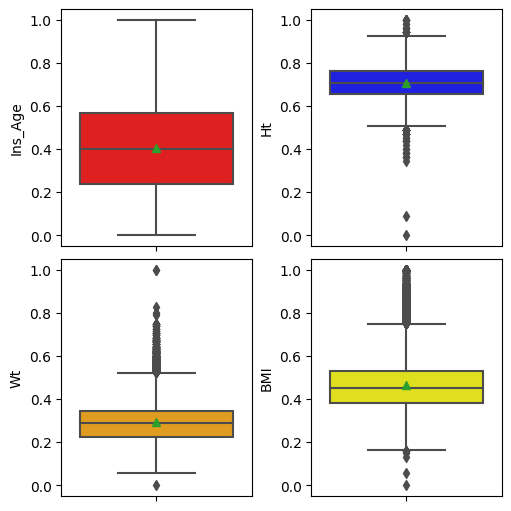

In [31]:
# display of Ins_Age, Ht, Wt, BMI variables

fig, ax = plt.subplots(2, 2, figsize=(5, 5), layout='constrained')

colors = ['red', 'blue', 'orange', 'yellow']

for col, an_axes, color in zip(['Ins_Age', 'Ht', 'Wt', 'BMI'], ax.flatten(), colors):
    sns.boxplot(data=df2_train, y=col, ax=an_axes, showmeans=True, color=color)
    an_axes.tick_params(axis='x', rotation=90)

plt.show()


The weight, height and BMI variables show a few outliers.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

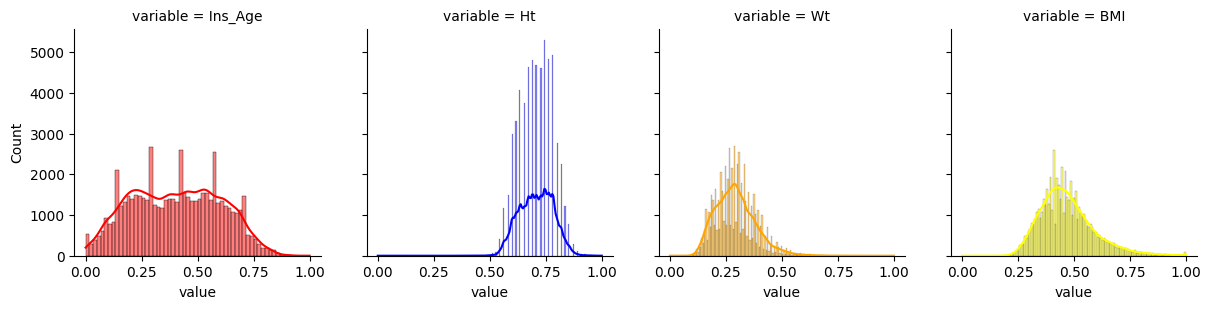

In [32]:
f = pd.melt(df2_train, value_vars=['Ins_Age', 'Ht', 'Wt', 'BMI'])

g = sns.FacetGrid(f, col='variable')

colors = ['red', 'blue', 'orange', 'yellow']

for ax, col, color in zip(g.axes.flat, ['Ins_Age', 'Ht', 'Wt', 'BMI'], colors):
    sns.histplot(data=f[f['variable'] == col], x='value',kde = True, ax=ax, color = color)

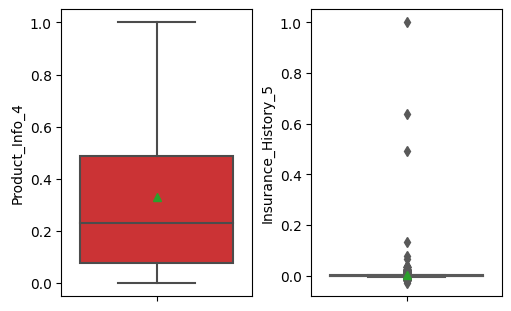

In [33]:
fig, ax = plt.subplots(1,2,figsize=(5, 3), layout='constrained')
sns.boxplot(data=df2_train, y='Product_Info_4', showmeans=True, ax=ax[0], palette = 'Set1')
sns.boxplot(data=df2_train, y= 'Insurance_History_5', showmeans=True, ax=ax[1],palette = 'Set2')
plt.show()

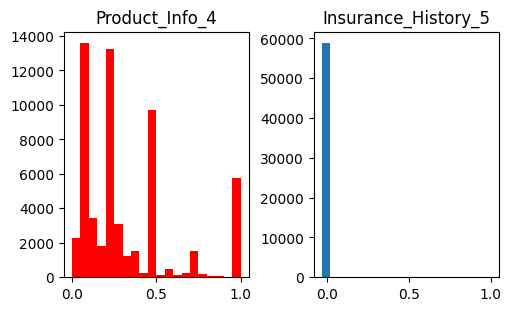

In [34]:
fig, ax = plt.subplots(1,2,figsize=(5, 3), layout='constrained')
ax[0].hist(x=df2_train['Product_Info_4'], color = 'red', bins = 20)
ax[0].set_title('Product_Info_4')
ax[1].hist(x=df2_train['Insurance_History_5'], bins= 20)
ax[1].set_title('Insurance_History_5')
plt.show()

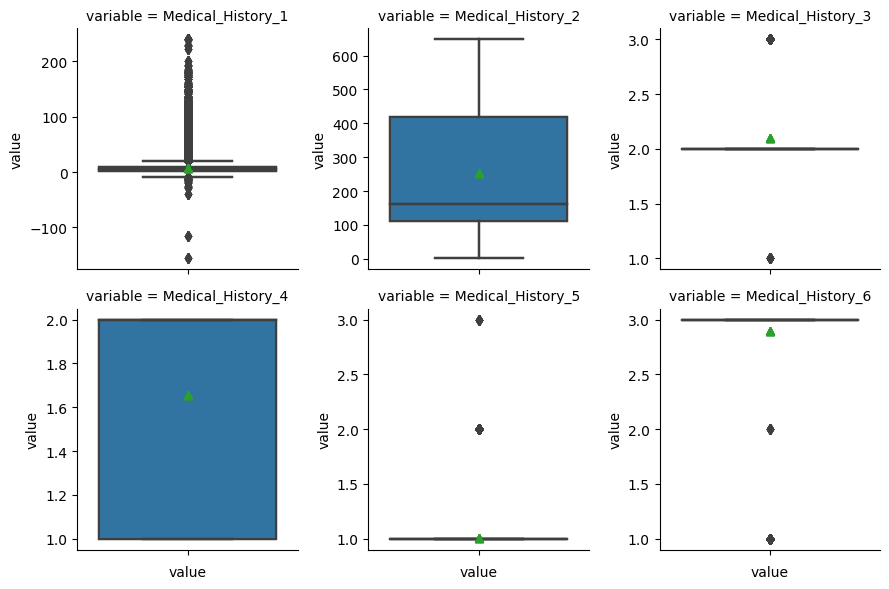

In [60]:
def boxplot(col,**kwargs):
    sns.boxplot(y=col, showmeans=True)
    
# Display Medical_History variables
cols_medical_history = [col for col in df2_train.columns if 'Medical' in col]
    
f = pd.melt(df2_train, value_vars = cols_medical_history[:6])
g = sns.FacetGrid(f, col = 'variable',col_wrap=3, sharex=False, sharey=False)

colors = ['red', 'blue', 'green', 'orange', 'yellow', 'grey']

for ax, col, color in zip(g.axes.flat, cols_medical_history[:6], colors):
    g.map(boxplot, "value", color=color, ax=ax)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

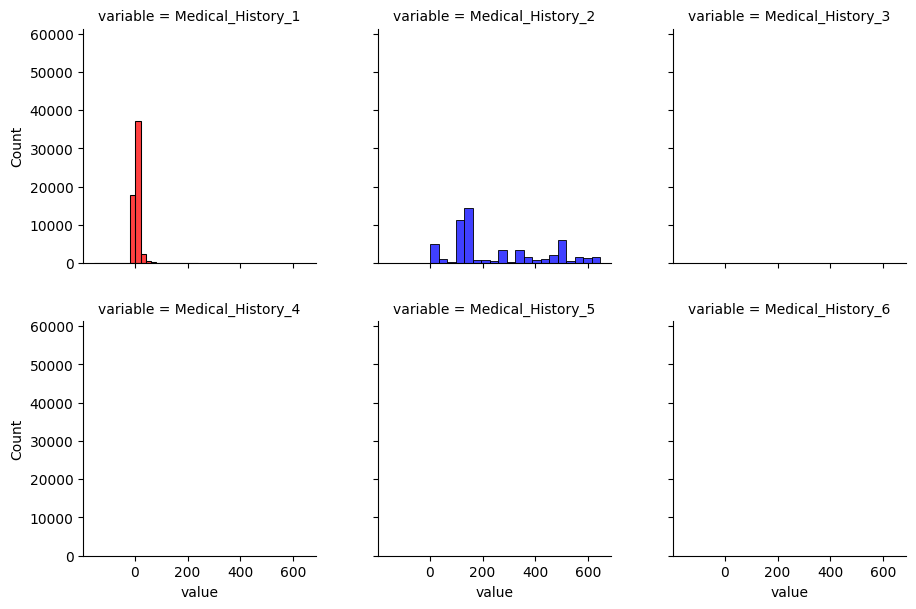

In [62]:
# Faire fondre le DataFrame
f = pd.melt(df2_train, value_vars=cols_medical_history[:6])


# Créer le FacetGrid
g = sns.FacetGrid(f, col='variable', col_wrap=3)

# Définir les couleurs pour chaque sous-graphique
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'grey']

# Mapper les histogrammes avec les couleurs spécifiées
for ax, col, color in zip(g.axes.flat, cols_medical_history[:6], colors):
    sns.histplot(data=f[f['variable'] == col], x='value', ax=ax, color=color, bins = 20)

# Afficher la figure
plt.show()

continuous variables Medical_History :

- None Variables relating to medical history follow a normal distribution


In [63]:
# Display Family_history variables
cols_family_history = [col for col in df2_train.columns if 'Family' in col]


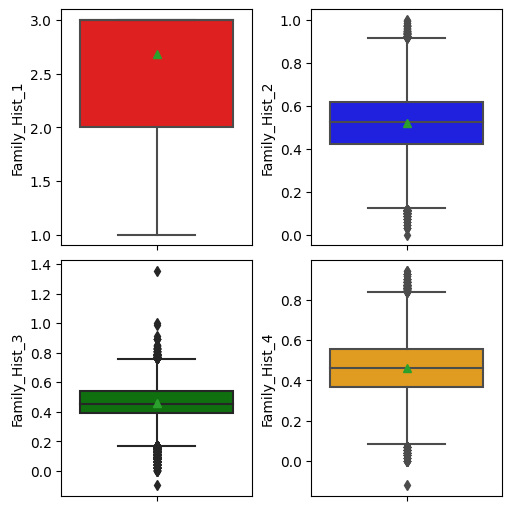

In [64]:
fig, ax = plt.subplots(2, 2 , figsize=(5, 5),layout = 'constrained')

colors = ['red', 'blue', 'green', 'orange']

for col, an_axes, color in zip(cols_family_history[:4], ax.flatten(), colors):
    sns.boxplot(data=df2_train, y=col, ax=an_axes, showmeans=True,color = color)
    an_axes.tick_params(axis='x', rotation=90)
plt.show();

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

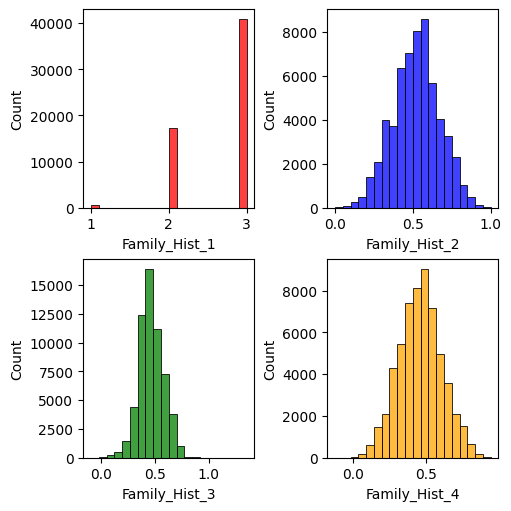

In [65]:
fig, ax = plt.subplots(2, 2 , figsize=(5, 5),layout = 'constrained')
colors = ['red', 'blue', 'green', 'orange']

for col, an_axes, color in zip(cols_family_history[:4], ax.flatten(), colors):
    sns.histplot(data=df2_train, x=col, ax=an_axes, color= color, bins =20)
    an_axes.tick_params(axis='x', rotation=0)
plt.show();

Text(0.5, 1.0, 'Unbalanced_class')

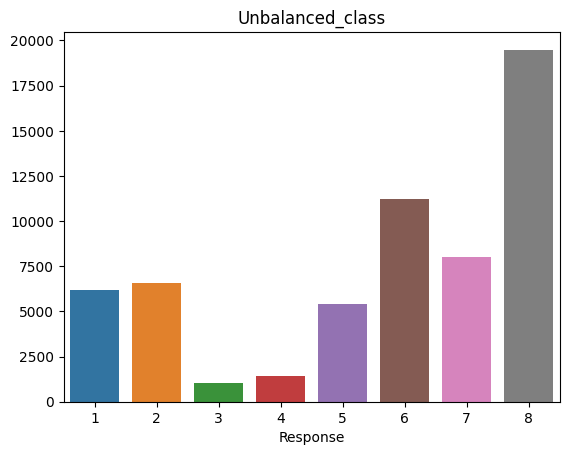

In [69]:
# unbalanced class
sns.barplot(x = dataset_train.Response.value_counts().index,y = dataset_train.Response.value_counts().values)
# The target values 3 and 4 are less represented than others.
plt.title('Unbalanced_class')

## 2.2 Tranformation of continuous variables with log


In [70]:
cols = ['Ins_Age','Ht','Wt','BMI','Family_Hist_3','Family_Hist_4', 'Family_Hist_5']

def df_log_transform(df, cols):
    for col in cols:
        df[col] = np.log1p(df[col])
    return df

df2_train = df_log_transform(df2_train, cols)
df2_test = df_log_transform(df2_test, cols)

# 3. Modelling

        
3.1 Select the best classifier models with grid search cv.

3.2 Then i will fine tune the model.


# 3.1 Select the best classifier models with Grid Search CV

In [106]:
cols=[col for col in df2_train.columns if col not in 'Response']
df2_train  = df2_train.fillna(0)
df2_train.isna().mean().sort_values(ascending = False)
X = df2_train.loc[:,cols]
y = df2_train.Response

In [84]:
quadratic_weighted_kappa = make_scorer(cohen_kappa_score, weights = 'quadratic')

In [85]:
param_grid = {'scaled':[StandardScaler(),MinMaxScaler(),'passthrough'],
              'estimator':[ lgb.LGBMClassifier(), RandomForestClassifier(), AdaBoostClassifier(), BaggingClassifier()]}

In [86]:
pipe = Pipeline([
                 ('scaled',StandardScaler()),
                 ('estimator',lgb.LGBMClassifier()),
                 ])

In [87]:
def quadratic_weighted_kappa(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    return cohen_kappa_score(y_test, y_pred, weights='quadratic')

grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=0, scoring=quadratic_weighted_kappa)

In [88]:
grid.fit(X, y)
grid_cv = pd.DataFrame(grid.cv_results_)
new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]
grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4646
[LightGBM] [Info] Number of data points in the train set: 58787, number of used features: 127
[LightGBM] [Info] Start training from score -2.290530
[LightGBM] [Info] Start training from score -2.214970
[LightGBM] [Info] Start training from score -4.068933
[LightGBM] [Info] Start training from score -3.718346
[LightGBM] [Info] Start training from score -2.389375
[LightGBM] [Info] Start training from score -1.661764
[LightGBM] [Info] Start training from score -1.996606
[LightGBM] [Info] Start training from score -1.105714


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaled,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,38.005576,5.408935,1.283800,0.119339,LGBMClassifier(),passthrough,"{'estimator': LGBMClassifier(), 'scaled': 'pas...",0.554664,0.003658,1,0.664796,0.001956
1,38.869637,7.710878,1.285983,0.114518,LGBMClassifier(),MinMaxScaler(),"{'estimator': LGBMClassifier(), 'scaled': MinM...",0.552749,0.006655,2,0.665564,0.002090
0,45.338212,12.064308,1.199391,0.077970,LGBMClassifier(),StandardScaler(),"{'estimator': LGBMClassifier(), 'scaled': Stan...",0.552292,0.004727,3,0.664444,0.002370
5,27.209197,0.249501,0.633692,0.026847,RandomForestClassifier(),passthrough,"{'estimator': RandomForestClassifier(), 'scale...",0.511078,0.004314,4,1.000000,0.000000
3,28.365969,1.089310,0.681030,0.018244,RandomForestClassifier(),StandardScaler(),"{'estimator': RandomForestClassifier(), 'scale...",0.511046,0.006355,5,0.999983,0.000035
4,27.489013,0.353440,0.638876,0.019308,RandomForestClassifier(),MinMaxScaler(),"{'estimator': RandomForestClassifier(), 'scale...",0.510691,0.006035,6,0.999987,0.000026
9,24.564388,0.138139,0.155127,0.036979,BaggingClassifier(),StandardScaler(),"{'estimator': BaggingClassifier(), 'scaled': S...",0.494571,0.007803,7,0.986535,0.000568
10,24.490584,0.497144,0.128461,0.010837,BaggingClassifier(),MinMaxScaler(),"{'estimator': BaggingClassifier(), 'scaled': M...",0.494173,0.003758,8,0.986750,0.000459
11,23.249712,1.520332,0.104297,0.012892,BaggingClassifier(),passthrough,"{'estimator': BaggingClassifier(), 'scaled': '...",0.494030,0.006860,9,0.985568,0.000614
8,10.492968,0.173208,0.229457,0.005034,AdaBoostClassifier(),passthrough,"{'estimator': AdaBoostClassifier(), 'scaled': ...",0.467925,0.012494,10,0.466901,0.009431


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.821695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4785
[LightGBM] [Info] Number of data points in the train set: 47029, number of used features: 127
[LightGBM] [Info] Start training from score -2.290517
[LightGBM] [Info] Start training from score -2.214879
[LightGBM] [Info] Start training from score -4.068920
[LightGBM] [Info] Start training from score -3.717983
[LightGBM] [Info] Start training from score -2.389363
[LightGBM] [Info] Start training from score -1.661796
[LightGBM] [Info] Start training from score -1.996656
[LightGBM] [Info] Start training from score -1.105740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

- The best score obtained is with the LightGBM algorithm. 
- Its train_score is greater than its test_score. It is a bit overfit. 
- Below i will search the best hyperparameters for this model.

# 3.2 Searching for the best hyperparameters for lightgbm

In [110]:
#the executing time for this cell last : 2500.16 secondes. in my local notebook, i execute this cell to find the best hyperparameters.
"""param_grid = {
                'estimator__n_estimators':[100,150],
                'estimator__max_depth':[60,70],
                'estimator__num_leaves' : [20,31],
                'estimator__min_child_samples' : [20,25],
                'estimator__learning_rate': [0.1,0.2]
              }

param_grid"""

"""pipe = Pipeline([('estimator',lgb.LGBMClassifier())])"""
#grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=0, scoring=quadratic_weighted_kappa)
#import time
#t0 = time.time()
#grid.fit(X, y)
#duration1=time.time() - t0
#print("time : ", "%15.2f" % duration1, "seconds")


#the best parameter
"""
grid.best_params_
{'estimator__learning_rate': 0.2,
 'estimator__max_depth': 60,
 'estimator__min_child_samples': 25,
 'estimator__n_estimators': 150,
 'estimator__num_leaves': 20}
 """

"\ngrid.best_params_\n{'estimator__learning_rate': 0.2,\n 'estimator__max_depth': 60,\n 'estimator__min_child_samples': 25,\n 'estimator__n_estimators': 150,\n 'estimator__num_leaves': 20}\n "

In [94]:
# The run of this cell is long (about 60 minutes)

"""from sklearn.feature_selection import RFECV

import time
t0 = time.time()

model_lgbm = lgb.LGBMClassifier( **best_params_lgbm, verbose=-1)


rfe = RFECV(estimator=model_lgbm, cv=5)
rfe.fit_transform(X, y)# The hyperparameters found

duration1=time.time() - t0
print("time : ", "%15.2f" % duration1, "seconds")"""


'from sklearn.feature_selection import RFECV\n\nimport time\nt0 = time.time()\n\nmodel_lgbm = lgb.LGBMClassifier( **best_params_lgbm, verbose=-1)\n\n\nrfe = RFECV(estimator=model_lgbm, cv=5)\nrfe.fit_transform(X, y)# The hyperparameters found\n\nduration1=time.time() - t0\nprint("time : ", "%15.2f" % duration1, "seconds")'

In [91]:
#X.columns[rfe.support_]

cols_selected = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
                 'Product_Info_5', 'Product_Info_6', 'Ins_Age', 'Ht', 'Wt', 'BMI',
                 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_4',
                 'Employment_Info_5', 'Employment_Info_6', 'InsuredInfo_1',
                 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5',
                 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1',
                 'Insurance_History_2', 'Insurance_History_4', 'Insurance_History_5',
                 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9',
                 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4',
                 'Family_Hist_5', 'Medical_History_1', 'Medical_History_2',
                 'Medical_History_3', 'Medical_History_4', 'Medical_History_5',
                 'Medical_History_6', 'Medical_History_7', 'Medical_History_8',
                 'Medical_History_9', 'Medical_History_10', 'Medical_History_11',
                 'Medical_History_12', 'Medical_History_13', 'Medical_History_15',
                 'Medical_History_16', 'Medical_History_17', 'Medical_History_18',
                 'Medical_History_19', 'Medical_History_20', 'Medical_History_21',
                 'Medical_History_22', 'Medical_History_23', 'Medical_History_24',
                 'Medical_History_25', 'Medical_History_27', 'Medical_History_28',
                 'Medical_History_29', 'Medical_History_30', 'Medical_History_31',
                 'Medical_History_32', 'Medical_History_33', 'Medical_History_34',
                 'Medical_History_35', 'Medical_History_36', 'Medical_History_37',
                 'Medical_History_39', 'Medical_History_40', 'Medical_History_41',
                 'Medical_Keyword_3', 'Medical_Keyword_9', 'Medical_Keyword_15',
                 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_25',
                 'Medical_Keyword_33', 'Medical_Keyword_35', 'Medical_Keyword_37',
                 'Medical_Keyword_38', 'Medical_Keyword_40', 'Medical_Keyword_41',
                 'Medical_Keyword_42', 'Medical_Keyword_47', 'Medical_Keyword']


In [120]:
def model(model, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X[cols_selected], y, test_size = 0.2)
    
    # standardisation 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return y_train, y_test, y_train_pred, y_test_pred, model

In [121]:
model_xgb = xgboost.XGBClassifier(learning_rate =0.038, max_depth = 12, n_estimators = 200,
                          objective ='multi:softmax', num_class = 8, random_state=1) 

y_train, y_test, y_train_pred, y_test_pred, model_xgboost = model(model_xgb, X, (y-1))

In [122]:
print('score test')

print(f' cohen_kappa_score: {cohen_kappa_score(y_test, y_test_pred, weights = "quadratic")}\n',
      f'accuracy score : {accuracy_score(y_test, y_test_pred)}\n',
      f'recall score :',recall_score(y_test, y_test_pred, average = 'weighted'),'\n',
      f'f1_score score :',f1_score(y_test, y_test_pred,average ='weighted'))

print('\nscore train')

print(f' cohen_kappa_score: {cohen_kappa_score(y_train, y_train_pred, weights = "quadratic")}\n',
      f'accuracy score : {accuracy_score(y_train, y_train_pred)}\n',
      f'recall score :',recall_score(y_train, y_train_pred, average = 'weighted'),'\n',
      f'f1_score score :',f1_score(y_train, y_train_pred,average ='weighted'))

score test
 cohen_kappa_score: 0.5526018217332245
 accuracy score : 0.5878550773941147
 recall score : 0.5878550773941147 
 f1_score score : 0.5617165354652911

score train
 cohen_kappa_score: 0.8453559697234126
 accuracy score : 0.8560887962746391
 recall score : 0.8560887962746391 
 f1_score score : 0.8549291522637592


In [128]:
# The hyperparameters found
best_params_lgbm = {'n_estimators': 150, 'max_depth': 60, 'num_leaves': 20, 'min_child_samples': 25, 'learning_rate': 0.2}

# Train model_lightgbm
model_lgbm = lgb.LGBMClassifier( **best_params_lgbm)

y_train, y_test, y_train_pred, y_test_pred, model_lgbm = model(model_lgbm, X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4541
[LightGBM] [Info] Number of data points in the train set: 47029, number of used features: 87
[LightGBM] [Info] Start training from score -2.290097
[LightGBM] [Info] Start training from score -2.223290
[LightGBM] [Info] Start training from score -4.116033
[LightGBM] [Info] Start training from score -3.691200
[LightGBM] [Info] Start training from score -2.389131
[LightGBM] [Info] Start training from score -1.661348
[LightGBM] [Info] Start training from score -1.990723
[LightGBM] [Info] Start training from score -1.105483


In [129]:
print('score test')

print(f' cohen_kappa_score: {cohen_kappa_score(y_test, y_test_pred, weights = "quadratic")}\n',
      f'accuracy score : {accuracy_score(y_test, y_test_pred)}\n',
      f'recall score :',recall_score(y_test, y_test_pred, average = 'weighted'),'\n',
      f'f1_score score :',f1_score(y_test, y_test_pred,average ='weighted'))

print('\nscore train')

print(f' cohen_kappa_score: {cohen_kappa_score(y_train, y_train_pred, weights = "quadratic")}\n',
      f'accuracy score : {accuracy_score(y_train, y_train_pred)}\n',
      f'recall score :',recall_score(y_train, y_train_pred, average = 'weighted'),'\n',
      f'f1_score score :',f1_score(y_train, y_train_pred,average ='weighted'))

score test
 cohen_kappa_score: 0.5493638216474627
 accuracy score : 0.5771389692124511
 recall score : 0.5771389692124511 
 f1_score score : 0.5542900980347091

score train
 cohen_kappa_score: 0.7389798546370773
 accuracy score : 0.7648472219268961
 recall score : 0.7648472219268961 
 f1_score score : 0.7578450177711124


In [130]:
feat_importances = pd.Series(data = model_lgbm.feature_importances_, index= model_lgbm.feature_name_).sort_values(ascending = False)
feat_importances_ =  pd.DataFrame(feat_importances, columns=['importances'])

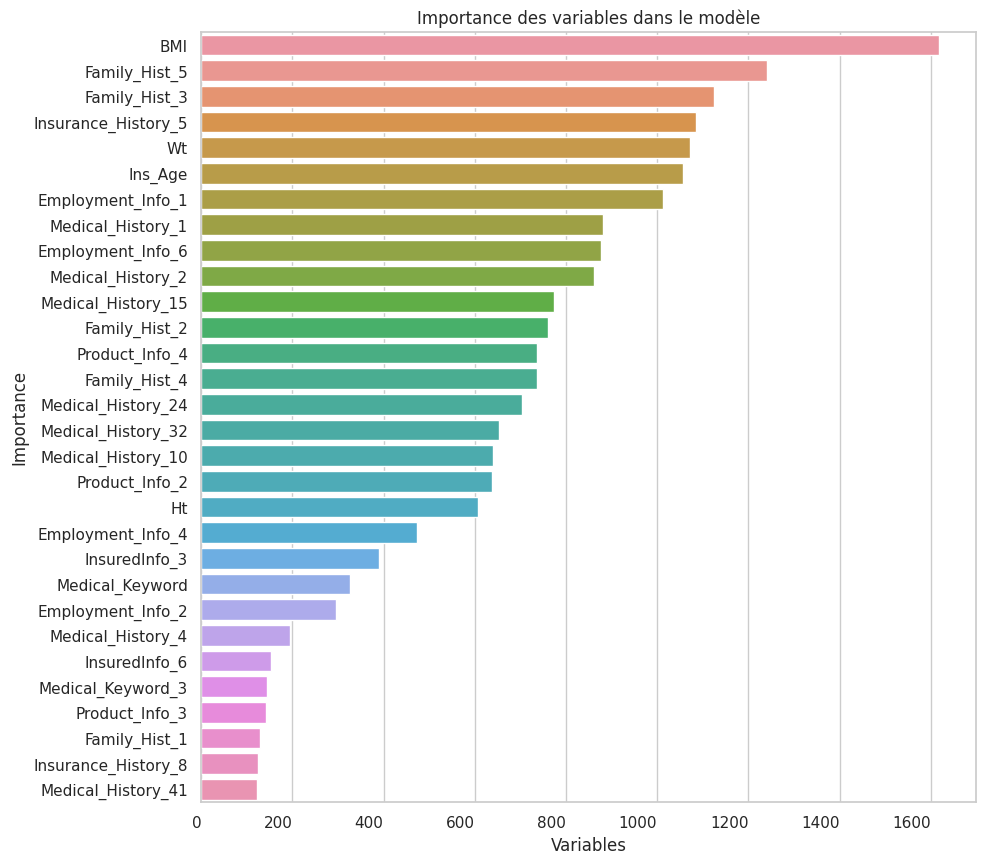

In [131]:

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=feat_importances_[:30] ,y = feat_importances_[:30].index, x ='importances', ax=ax)

# Mise en oblique des étiquettes
plt.xticks(rotation=0, ha='right')

# Titre et axes
plt.title("Importance des variables dans le modèle")
plt.xlabel("Variables")
plt.ylabel("Importance")

plt.show()

In [132]:
Id = dataset_test.Id
Id
df2_test = df2_test.fillna(0)
X = df2_test[cols_selected]
X = X.apply(lambda x: x.astype(float))
y_pred = model_lgbm.predict(X)

In [133]:
Id = dataset_test.Id

In [134]:
df_test = pd.concat((Id,pd.DataFrame(y_pred,columns=['Response'])), axis =1)
df_test

,Id,Response
0,1,2
1,3,6
2,4,6
3,9,2
4,12,6
...,...,...
19760,79093,8
19761,79099,8
19762,79102,5
19763,79125,2


<Axes: xlabel='Response', ylabel='count'>

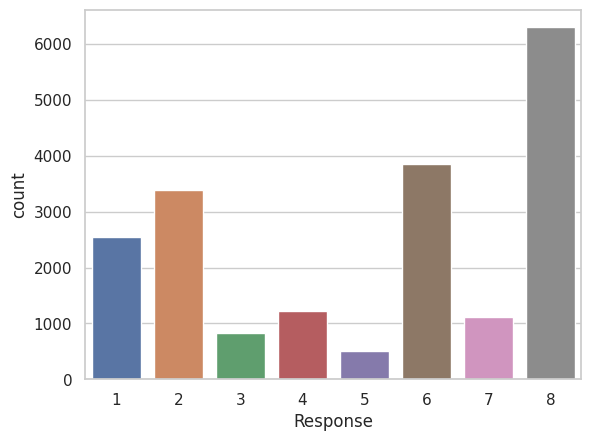

In [135]:
list(df_test.Response.values).count(4)
sns.countplot(data=df_test,x='Response')

In [136]:
df_test.to_csv("/kaggle/working/sample_submission.csv", index=False)